# Classification

## Install Fastai

In [5]:
!pip install -Uuq fastai


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


## Import fastai and download the pets dataset

The pets dataset is downloaded from the fast.ai datasets collection. The **untar_data() **function returns a Path object with the extracted location.

Fastai library doesn't just return a string containing the path to the dataset, but a Path object which is easier to work with.

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'
print(path)

/root/.fastai/data/oxford-iiit-pet/images


## Data Description
The Pet dataset has 7,390 pictures of dogs and cats, consisting of 37 different breeds.

Each image is labeled using its filename: e.g the file great_pyrenees_173.jpg is the 173rd example of an image of a Great Pyrenees breed dog in the dataset.

### Define is_cat function which labels cats based on a filename rule provided by the dataset creator.

In [3]:
def is_cat(x): return x[0].isupper()


The filenames start with an uppercase letter if the image is a cat, and a lowercase letter if its a dog.

Fastai gets labels from the filenames,by calling from_name_func (which means that labels can be extracted using a function applied to the filename), and passing is_cat, which returns x[0].isupper(), which evaluates to True if the first letter is uppercase (i.e., it's a cat).

## Use the ImageDataLoaders class

In [4]:
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

The first part of the class name will generally be the type of data you have, such as image, or text.

The parameter **valid_pct=0.2** tells fastai to hold out 20% of the data as a validation set. The validation set is used to measure the accuracy of the model.

The parameter **seed=42** sets the random seed to the same value every time we run this code, which means we get the same validation set every time we run it—this way, if we change our model and retrain it, we know that any differences are due to the changes to the model, not due to having a different random validation set.

### define the Transforms

A Transform contains code that is applied automatically during training; fastai includes many predefined Transforms. You can add new ones by creating a Python function.

There are two types:
- item_tfms are applied to each item (in this case, each item is resized to a 224-pixel square).
- batch_tfms are applied to a batch of items at a time using the GPU, so they are fast.

Why 224 pixels? This is the standard size for historical reasons (old pretrained models require this size exactly), but you can pass anything.

If you increase the size, you will often get a model with better results (since it will be able to focus on more details), but at the price of speed and memory consumption; if you decrease the size the results may be worse.

## Create a convolutional neural network (CNN)

Pass the specific architecture to use (i.e. what kind of model to create), what data we want to train it on, and what metric to use to **vision_learner**.

In [5]:
learn = vision_learner(dls, resnet34, metrics=error_rate)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 242MB/s]


 > ResNet it is both fast and accurate for many datasets and problems.
 The 34 in resnet34 refers to the number of layers in this variant of the architecture (other options are 18, 50, 101, and 152).
 Models using architectures with more layers take longer to train, and are more prone to overfitting (i.e. you can't train them for as many epochs before the accuracy on the validation set starts getting worse). Using more data, they can be quite a bit more accurate.

A metric is a function that measures the quality of the model's predictions using the validation set, and will be printed at the end of each epoch.

The error_rate indicates what percentage of images in the validation set are being classified incorrectly.

Accuracy is **1.0 - error_rate**.

***vision_learner*** also has a parameter pretrained, which defaults to True (so it's used in this case, even though we haven't specified it), which sets the weights in your model to values that have already been trained by experts to recognize a thousand different categories across 1.3 million photos (using the ImageNet dataset).

When using a pretrained model, vision_learner will remove the last layer, since that is always specifically customized to the original training task (i.e. ImageNet dataset classification), and replace it with one or more new layers with randomized weights, of an appropriate size for the dataset you are working with. This last part of the model is known as the **head**.

To fit a model, indicate how many times to look at each image (known as number of epochs).

The number of epochs you select will largely depend on how much time you have available, and how long you find it takes in practice to fit your model. If you select a number that is too small, you can always train for more epochs later.

In [6]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.176459,0.021875,0.006766,00:50


epoch,train_loss,valid_loss,error_rate,time
0,0.059269,0.014749,0.002706,00:47


>why is the method called fine_tune, and not fit?
---

The **fit metho**d fits a model (i.e. look at images in the training set multiple times, each time updating the parameters to make the predictions closer and closer to the target labels).

The **fine_tune** method is used because we started with a pretrained model, and we don't want to throw away all those capabilities that it already has.

# Segmentation
Segmentation refers to creating a model that can recognize the content of every individual pixel in an image.


### Import fastai and download a subset of the Camvid dataset
The dataset is from the paper "Semantic Object Classes in Video: A High-Definition Ground Truth Database" by Gabruel J. Brostow, Julien Fauqueur, and Roberto Cipolla:

In [7]:
path = untar_data(URLs.CAMVID_TINY)

Use the SegmentatationDataLoaders class to load the data and specify the labels.

In [8]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

Use the **unet_learner** to pass in the data and CNN architecture to be used.

In [9]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(8) # fine tune o 8 epochs.

epoch,train_loss,valid_loss,time
0,2.932047,3.679623,00:02


epoch,train_loss,valid_loss,time
0,2.069242,1.651055,00:01
1,1.731579,1.343739,00:01
2,1.555133,1.202977,00:01
3,1.395920,0.900599,00:01
4,1.246691,0.837488,00:01
5,1.120032,0.770103,00:01
6,1.020212,0.736204,00:01
7,0.942402,0.730833,00:01


### visualize how well the model achieved its task

 color-code each pixel of an image. As you can see, it nearly perfectly classifies every pixel in every object. For instance, notice that all of the cars are overlaid with the same color and all of the trees are overlaid with the same color (in each pair of images, the lefthand image is the ground truth label and the right is the prediction from the model)

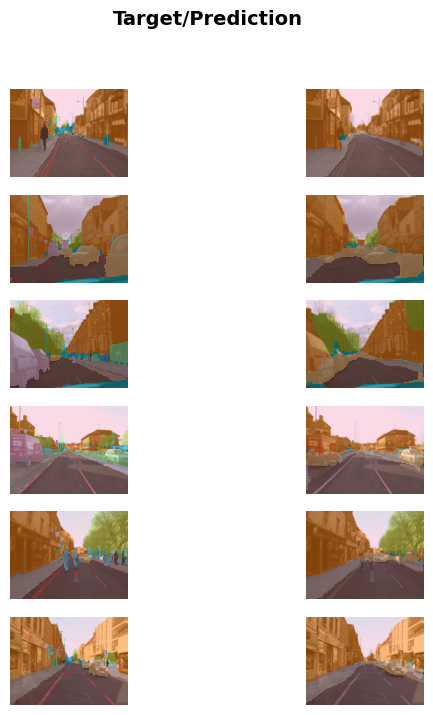

In [10]:
learn.show_results(max_n=6, figsize=(7,8))


# Sentiment Classification
classify the sentiment of a movie review

In [11]:

from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.467337,0.444478,0.785800,03:34


epoch,train_loss,valid_loss,accuracy,time
0,0.302700,0.289047,0.887680,07:20
1,0.246544,0.220405,0.911360,07:19
2,0.185955,0.186006,0.928200,07:19
3,0.146184,0.193845,0.927200,07:20


The model is using the "IMDb Large Movie Review dataset" from paper "Learning Word Vectors for Sentiment Analysis" by Andrew Maas et al.

Use the TextDataLoaders class to load the data and fine tune using 4 epochs and a learning rate of  **1e-2**

In [12]:
learn.predict("I really liked that movie!")

('pos', tensor(1), tensor([2.9301e-04, 9.9971e-01]))

 # Tabular Data


Use the Adult dataset, from "Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid" by Rob Kohavi, which contains some demographic data about individuals (e.g education, marital status, race, sex, annual income greater than $50k) etc.

Specify which columns are categorical (that is, contain values that are one of a discrete set of choices, such as occupation) and which are continuous (that is, contain a number that represents a quantity, such as age).

In [1]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)




> There is no pretrained model available for this task (in general, pretrained models are not widely available for any tabular modeling tasks, althoug, so we use ***fit_one_cycle*** method , the most commonly used method for training fastai models from scratch (i.e. without transfer learning):

In [2]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.381825,0.363111,0.824939,00:03
1,0.352660,0.359420,0.828163,00:03
2,0.348034,0.356435,0.830160,00:03


# Recommendation System
 Predict movies people might like, based on their previous viewing habits, using the MovieLens dataset:

In [3]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.500727,1.416835,00:00


epoch,train_loss,valid_loss,time
0,1.375910,1.362702,00:00
1,1.288096,1.192742,00:00
2,1.040758,0.885494,00:00
3,0.816077,0.724778,00:00
4,0.704944,0.681797,00:00
5,0.654109,0.667281,00:00
6,0.628589,0.660501,00:00
7,0.610293,0.657127,00:00
8,0.610632,0.655915,00:00
9,0.606684,0.655741,00:00


This model is predicting movie ratings on a scale of 0.5 to 5.0 to within around 0.6 average error.

Use the **y_range** parameter to specify the range of our target variables because we are predicting a continuous variable.

We can use the same show_results call we saw earlier to view a few examples of user and movie IDs, actual ratings, and predictions:

In [4]:
learn.show_results()


,userId,movieId,rating,rating_pred
0,48.0,5.0,5.0,3.619980
1,52.0,19.0,2.0,2.604195
2,25.0,29.0,4.0,3.742929
3,49.0,6.0,5.0,4.278661
4,59.0,49.0,4.0,4.266638
5,67.0,9.0,3.0,3.111912
6,98.0,8.0,4.5,4.394624
7,46.0,82.0,2.0,3.197997
8,44.0,32.0,3.0,3.257712
